In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from skimage import util
from math import exp, log
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.keras import layers
from matplotlib import rc
rc('mathtext', default='regular')

In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'imagenette',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size-v2/0.1.0.incompleteZAW42R/imagenette-train.tfrecord


  0%|          | 0/9469 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imagenette/full-size-v2/0.1.0.incompleteZAW42R/imagenette-validation.tfrecord


  0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size-v2/0.1.0. Subsequent calls will reuse this data.


In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

10


In [5]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [6]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets.
    ds = ds.batch(batch_size)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [7]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [8]:
IMG_SHAPE = (180, 180, 3)
base_model = tf.keras.applications.resnet.ResNet101(input_shape=IMG_SHAPE,
                            include_top=False,
                            weights='imagenet')         

171458560/171446536 [==============================] - 2s 0us/step


In [9]:
model_bot = tf.keras.Model(inputs=base_model.layers[0].output, outputs=base_model.layers[18].output)

In [10]:
model_bot.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']         

In [11]:
kernelsize = 3
filters_num1 = 32
filters_num2 = 64
filters_num3 = 64
trust_res = []
train_acc = []
train_loss = []
y_update_wb = []
y_N_opinion = []
y_pred_list = []
y_true_op = [1.0, 0.0, 0.0, 0.5]
x_data_op = [1.0, 0.0, 0.0, 0.5]
w_initial = [0.0, 0.0, 1.0, 0.5]
b_initial = [0.0, 0.0, 1.0, 0.5]

In [12]:
# functional API
inputs = tf.keras.Input(shape=(180, 180, 3))
x = model_bot(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=64, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dense(units=num_classes)(x)
outputs = tf.keras.layers.Softmax()(x)   

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 model (Functional)          (None, 45, 45, 256)       86656     
                                                                 
 flatten (Flatten)           (None, 518400)            0         
                                                                 
 dense (Dense)               (None, 64)                33177664  
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
 softmax (Softmax)           (None, 10)                0         
                                                                 
Total params: 33,264,970
Trainable params: 33,263,562
Non-t

In [13]:
# model.layers[1].trainable = False

In [14]:
# forward opinion prop
def mul_scale(W_x):
    mul_u = 1.0
    for i in range(len(W_x)):
        mul_u = mul_u * W_x[i]
        if mul_u <= 1e-40: 
            mul_u = mul_u*1e41
    return mul_u

def fusion(W_x): # W_x array

    deno = 0.0
    mole = 0.0
    full_multi = mul_scale(W_x[:,2])
    for i in range(len(W_x[:,2])):
        deno = deno + full_multi/W_x[:,2][i]
        mole = mole + (full_multi/W_x[:,2][i])*W_x[:,0][i]
    W_b = mole/deno  #  change
    W_u = (len(W_x)*full_multi)/deno   # change
    W_a = sum(W_x[:,3])/len(W_x)  

#     W_b = sum(1/len(W_x)*W_x[:,0])
#     W_u = 0.0
#     W_a = sum(1/len(W_x)*W_x[:,3])
        
    return [W_b,1-W_b-W_u,W_u,W_a]

def avg_fusion_dense(W_wx):
    """
    input - (node_num, 4)
    
    return opinion - 4,32,50
    """
    W_wx = np.moveaxis(W_wx, 0, -1).astype(np.float64) # 4，node_num
    num_para = W_wx.shape[0]
    b_combine, u_combine, a_combine = W_wx[0], W_wx[2], W_wx[3]
    u_combine_recip = (np.zeros(u_combine.shape)+1)/u_combine
    
    numerator = np.sum(b_combine * u_combine_recip) # (32, 50)
    denominator = np.sum(u_combine_recip)
    
    b_fusion = numerator / denominator
    u_fusion = num_para / denominator
    a_fusion = np.sum(a_combine) / num_para
    out_opinion = np.array([b_fusion, 1-b_fusion-u_fusion, u_fusion, a_fusion]).astype(np.float32)
    
    return np.moveaxis(out_opinion, 0, -1)

def fusion_2(W_x, W_y):
    if W_x[2]!=0 or W_y[2]!=0:
        W_b = (W_x[0]*W_y[2]+W_y[0]*W_x[2])/(W_x[2]+W_y[2])
        W_u = 2*W_x[2]*W_y[2]/(W_x[2]+W_y[2])
        W_a = (W_x[3]+W_y[3])/2  
    elif W_x[2]==0 and W_y[2]==0:
        W_b = 0.5*W_x[0]+0.5*W_y[0]
        W_u = 0
        W_a = 0.5*W_x[3]+0.5*W_y[3]
    return [W_b,1-W_b-W_u,W_u,W_a]

def multi(W_x, W_y): # 
    W_b = W_x[0]*W_y[0]+((1-W_x[3])*W_y[3]*W_x[0]*W_y[2]+W_x[3]*(1-W_y[3])*W_y[0]*W_x[2])/(1-W_x[3]*W_y[3])
    W_d = W_x[1]+W_y[1]-W_x[1]*W_y[1]
    W_u = W_x[2]*W_y[2]+((1-W_y[3])*W_x[0]*W_y[2]+(1-W_x[3])*W_y[0]*W_x[2])/(1-W_x[3]*W_y[3])
    W_a = W_x[3]*W_y[3]
    return [W_b,W_d,W_u,W_a]

def get_opinion(r,num_batches): # r -> W
    return [r/(num_batches+2), (num_batches-r)/(num_batches+2), 2/(num_batches+2), 0.5]

def evidence_collect(y, y_pred):
    r = 0
    s = 0
    r_list = [0]*len(y_pred[0])
    s_list = [0]*len(y_pred[0])
    
    for j in range(len(y_pred)):
        for i in range(len(y_pred[0])):
            if i == y[j]:
                if y_pred[j][i] > 0.45:
                    r_list[i]+=1
                    r+=1
                else:
                    s+=1
                    s_list[i]+=1
            else:
                if y_pred[j][i] < 0.05:
                    r_list[i]+=1
                else:
                    s_list[i]+=1
                    
    y_N_op = []
    for i in range(len(r_list)):
        y_N_op.append([r_list[i]/(r_list[i]+s_list[i]+2), 
                       s_list[i]/(r_list[i]+s_list[i]+2), 2/(r_list[i]+s_list[i]+2), 0.5])

    
    return [r/(r+s+2), s/(r+s+2), 2/(r+s+2), 0.5], y_N_op

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
sparse_categorical_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [16]:
# training process
batch_index = 0
for i in range(5):
    for X,y in train_ds:
        print('# of batch:',batch_index)
        with tf.GradientTape() as tape:
            y_pred = model(X)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y, y_pred=y_pred)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))

        sparse_categorical_accuracy.update_state(y_true=y, y_pred=y_pred)
        y_pred_list.append(y_pred)
        train_loss.append(tf.reduce_mean(loss).numpy())
        train_acc.append(sparse_categorical_accuracy.result().numpy())
        print("train accuracy:",sparse_categorical_accuracy.result().numpy())

        y_N_update, y_N_op = evidence_collect(y, y_pred)
        y_N_opinion.append(y_N_op)
        y_update_wb.append(y_N_update)

        batch_index+=1

# of batch: 0
train accuracy: 0.03125
# of batch: 1
train accuracy: 0.09375
# of batch: 2
train accuracy: 0.09375
# of batch: 3
train accuracy: 0.109375
# of batch: 4
train accuracy: 0.10625
# of batch: 5
train accuracy: 0.114583336
# of batch: 6
train accuracy: 0.09821428
# of batch: 7
train accuracy: 0.09375
# of batch: 8
train accuracy: 0.09375
# of batch: 9
train accuracy: 0.096875
# of batch: 10
train accuracy: 0.10795455
# of batch: 11
train accuracy: 0.111979164
# of batch: 12
train accuracy: 0.11298077
# of batch: 13
train accuracy: 0.109375
# of batch: 14
train accuracy: 0.10625
# of batch: 15
train accuracy: 0.103515625
# of batch: 16
train accuracy: 0.0992647
# of batch: 17
train accuracy: 0.098958336
# of batch: 18
train accuracy: 0.097039476
# of batch: 19
train accuracy: 0.1
# of batch: 20
train accuracy: 0.10119048
# of batch: 21
train accuracy: 0.09801137
# of batch: 22
train accuracy: 0.095108695
# of batch: 23
train accuracy: 0.09375
# of batch: 24
train accuracy: 0.0

In [17]:
# compute Backward opinion of neuron W_N_Y  
W_N_Y=[]
for i in range(len(y_N_opinion)):
    W_N=[]
    for j in y_N_opinion[i]:
        W_N.append(multi(j,y_true_op)) # change when add flaw in label
    W_N_Y.append(W_N)

In [18]:
# compute forward prop opinion W_NX
W_NX_res=[]
x_data_op_list = []
conv1_out_list = []
conv2_out_list = []
conv3_out_list = []
dense1_out_list = []
dense2_out_list = []
flatten_num = model.layers[-4].output_shape[1]

for i in range(len(y_update_wb)):
  W_w=y_update_wb[i]
  W_b=y_update_wb[i]

  # first conv layer
  W_xw=[]
  W_xw.append(W_b)
  for j in range(kernelsize*kernelsize*3):
      W_xw.append(multi(W_w,x_data_op))
  conv1_out = fusion(np.array(W_xw))
  conv1_out_list.append(conv1_out)

  # second conv layer
  W_xw=[]
  W_xw.append(W_b)
  for j in range(kernelsize*kernelsize*filters_num1):
      W_xw.append(multi(W_w,conv1_out))
  conv2_out = fusion(np.array(W_xw))
  conv2_out_list.append(conv2_out)
  
  # third conv layer
  W_xw=[]
  W_xw.append(W_b)
  for j in range(kernelsize*kernelsize*filters_num2):
      W_xw.append(multi(W_w,conv2_out))
  conv3_out = fusion(np.array(W_xw))
  conv3_out_list.append(conv3_out)

  conv_out = fusion_2(conv3_out,[0,0,1,0.5])
  dense1_out_list.append(conv_out)
#   # first dense layer
#   W_xw=[]
#   W_xw.append(W_b)
#   for j in range(flatten_num):
#       W_xw.append(multi(W_w,conv_out))
#   dense_out = fusion(np.array(W_xw))
#   dense1_out_list.append(dense_out)
#     print('Underflow or not: ',np.isnan(np.min(np.array(dense1_out_list))))

#   # last layer
#   W_xw=[]
#   W_xw.append(W_b)
#   for j in range(64):
#       W_xw.append(multi(W_w,dense_out))
#   W_NN = fusion(np.array(W_xw))
#   W_NX_res.append(W_NN)

In [19]:
# compute last layer output opinion and trust
W_XY = []
for i in range(len(dense1_out_list)):
    W_XY_one = []
    for j in range(5):
        W_XY_one.append(fusion_2(dense1_out_list[i],W_N_Y[i][j]))
    W_XY.append(W_XY_one)
    
W_NN = []
for i in range(len(W_XY)):
    W_NN.append(avg_fusion_dense(np.array(W_XY[i])))

W_NN_trust=[]
for i in W_NN:
    W_NN_trust.append(i[0]+i[2]*i[3])

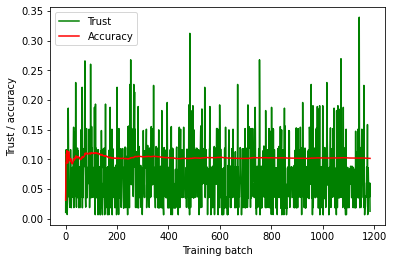

In [20]:
fig = plt.figure()
plt.xlabel('Training batch')
plt.ylabel('Trust / accuracy')
plt.plot(W_NN_trust, color='green', label='Trust')
plt.plot(train_acc, color='red', label='Accuracy')
plt.legend()

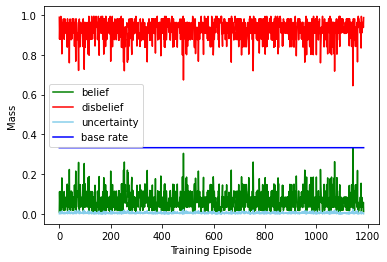

In [21]:
plt.plot([i for i in range(len(W_NN))], [i[0] for i in W_NN], color='green', label='belief')
plt.plot([i for i in range(len(W_NN))], [i[1] for i in W_NN], color='red', label='disbelief')
plt.plot([i for i in range(len(W_NN))], [i[2] for i in W_NN],  color='skyblue', label='uncertainty')
plt.plot([i for i in range(len(W_NN))], [i[3] for i in W_NN], color='blue', label='base rate')
plt.legend() # 显示图例

plt.xlabel('Training Episode')
plt.ylabel('Mass')
plt.show()

In [22]:
import pickle
def save_variable(v,filename):
    f=open(filename,'wb')
    pickle.dump(v,f)
    f.close()
    return filename
 
def load_variavle(filename):
    f=open(filename,'rb')
    r=pickle.load(f)
    f.close()
    return r

In [23]:
save_variable(W_NN, 'ResNet_opinion_training')
save_variable(W_NN_trust, 'ResNet_trust_training')
save_variable(train_acc, 'ResNet_acc_training')

'ResNet_acc_training'